<a href="https://colab.research.google.com/github/Supakrit65/Habermans-Survival-Classification/blob/main/binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import List, Dict

from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/ML/Dataset/Binary-Classification/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/ML/Dataset/Binary-Classification


In [3]:
dataset = pd.read_csv('haberman.csv')
dataset.columns = ["Age", "Op_Year", "axil_nodes", "Surv_status"]
dataset["Surv_status"] = dataset["Surv_status"] - 1
dataset.head()

,Age,Op_Year,axil_nodes,Surv_status
0,30,62,3,0
1,30,65,0,0
2,31,59,2,0
3,31,65,4,0
4,33,58,10,0


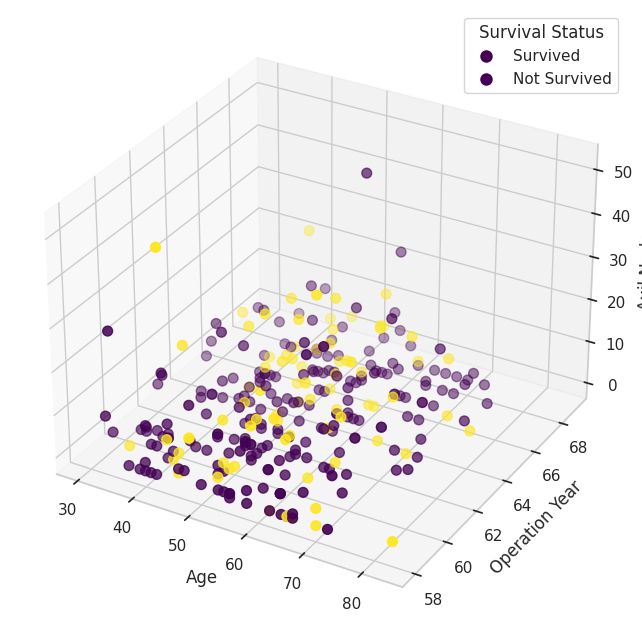

In [4]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(dataset['Age'], dataset['Op_Year'], dataset['axil_nodes'], c=dataset['Surv_status'], cmap='viridis', s=50)

ax.set_xlabel('Age')
ax.set_ylabel('Operation Year')
ax.set_zlabel('Axil Nodes')

legend_labels = ['Survived', 'Not Survived']
proxies = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.get_cmap()(i), markersize=10, label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=proxies, title='Survival Status')

plt.show()

In [5]:
# Separate features and target variable
X = dataset.drop("Surv_status", axis=1)
y = dataset["Surv_status"]

# Normalize the input features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Perform an 80/20 train-test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to NumPy arrays
train_x = train_x.to_numpy().T
train_y = train_y.to_numpy().reshape(1, -1)
test_x = test_x.to_numpy().T
test_y = test_y.to_numpy().reshape(1, -1)

In [6]:
m_train = train_x.shape[1]
m_test = test_x.shape[1]
print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print("x_train shape: " + str(train_x.shape))
print ("y_train shape: " + str(train_y.shape))
print("x_test shape: " + str(test_x.shape))
print ("y_test shape: " + str(test_y.shape))

Number of training examples: 244
Number of testing examples: 61
x_train shape: (3, 244)
y_train shape: (1, 244)
x_test shape: (3, 61)
y_test shape: (1, 61)


In [7]:
def initialize_parameters_deep(layer_dims: List[int]) -> Dict[str, float]:
  """
  Returns:
  parameters (Dict[str, float]): A dictionary containing the initialized parameters for the network.
                                  It includes weight matrices 'W1', 'W2', ..., 'WL' and bias vectors 'b1', 'b2', ..., 'bL'
                                  where L is the number of layers.
  """
  np.random.seed(3)
  parameters = {}
  L = len(layer_dims)

  for l in range(1, L):
      # Xavier initialization for hidden layers
      if l < L - 1:
          scale = np.sqrt(2 / (layer_dims[l - 1] + layer_dims[l]))
      else:
          scale = 0.01

      parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * scale
      parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

      assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
      assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

  return parameters

In [8]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z)), Z

def relu(Z):
    A = np.maximum(0, Z)
    return A, Z

In [9]:
def linear_forward(A, W, b):
  """
  Returns:
  Z -- pre-activation parameter
  """
  Z = np.dot(W, A) + b
  cache = (A, W, b)
  return Z, cache

def linear_activation_forward(A_prev, W, b, activation_type:str):
  """
  Returns:
  A -- activation parameter
  cache -- a python tuple containing "linear_cache" and "activation_cache";
           stored for computing the backward pass efficiently
  """
  if activation_type == "sigmoid":
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = sigmoid(Z)
  else: # activation_type == "relu"
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = relu(Z)

  cache = (linear_cache, activation_cache) # (A_prev, W, b, Z)
  return A, cache

In [10]:
def L_model_forward(X, parameters):
  """
  Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
  """
  caches = []
  A = X
  L = len(parameters) // 2 # number of layers in the neural network

  # Implement [LINEAR -> RELU]*(L-1)
  for l in range(1, L):
    A_prev = A
    W = parameters["W" + str(l)]
    b = parameters["b" + str(l)]
    A, cache = linear_activation_forward(A_prev, W, b, "relu")
    caches.append(cache)

  # Implement LINEAR -> SIGMOID.
  WL = parameters["W" + str(L)]
  bL = parameters["b" + str(L)]
  AL, cache = linear_activation_forward(A, WL, bL, "sigmoid")
  caches.append(cache)

  return AL, caches

In [11]:
def compute_cost(AL, Y):
  """
  Returns:
  cost - cross-entropy cost
  """
  m = Y.shape[1]
  cost = (-1/m) * np.sum(Y*np.log(AL) + (1 - Y)*np.log(1 - AL))
  cost = np.squeeze(cost)

  return cost

In [12]:
def relu_backward(dA, cache):
  """
  Returns:
  dZ: Gradient of the cost with respect to Z (input of the ReLU activation).
  """
  Z = cache
  dZ = np.array(dA, copy=True)
  dZ[Z <= 0] = 0
  assert (dZ.shape == Z.shape)
  return dZ

def sigmoid_backward(dA, cache):
  """
  Returns:
  dZ: Gradient of the cost with respect to Z (input of the sigmoid activation).
  """
  Z = cache
  s = 1/(1+np.exp(-Z))
  dZ = dA * s * (1-s)
  assert (dZ.shape == Z.shape)
  return dZ

In [13]:
def linear_backward(dZ, cache):
  """
  Compute gradients for a linear layer in the backward pass.

  Args:
  dZ: Gradient of the cost with respect to Z (output of linear step).
  cache: Tuple containing A_prev (activations from previous layer), W (weights), and b (bias).

  Returns:
  dA_prev: Gradient of the cost with respect to activations of previous layer.
  dW: Gradient of the cost with respect to weights.
  db: Gradient of the cost with respect to biases.
  """
  A_prev, W, b = cache
  m = A_prev.shape[1]

  dW = (1/m) * np.dot(dZ, A_prev.T)
  db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
  dA_prev = np.dot(W.T, dZ)

  return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation_type):
  """
  Compute gradients for a linear activation layer in the backward pass.

  Args:
  dA: Gradient of the cost with respect to the output of the activation.
  cache: Tuple containing linear_cache and activation_cache.
  activation_type: Type of activation function ("relu" or "sigmoid").

  Returns:
  dA_prev: Gradient of the cost with respect to activations of previous layer.
  dW: Gradient of the cost with respect to weights.
  db: Gradient of the cost with respect to biases.
  """
  linear_cache, activation_cache = cache

  if activation_type == "relu":
    dZ = relu_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
  else: # activation_type == "sigmoid"
    dZ = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)

  return dA_prev, dW, db

In [14]:
def L_model_backward(AL, Y, caches):
  grads = {}
  L = len(caches)
  m = AL.shape[1]
  Y = Y.reshape(AL.shape)

  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL

  current_cache = caches[L - 1]
  dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
  grads["dA" + str(L-1)] = dA_prev_temp
  grads["dW" + str(L)] = dW_temp
  grads["db" + str(L)] = db_temp

  # Loop from l=L-2 to l=0
  for l in reversed(range(L-1)):
      current_cache = caches[l]
      dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads['dA' + str(l+1)], current_cache, "relu")
      grads["dA" + str(l)] = dA_prev_temp
      grads["dW" + str(l + 1)] = dW_temp
      grads["db" + str(l + 1)] = db_temp

  return grads

In [15]:
def initialize_adam(parameters):
  L = len(parameters) // 2
  v = {}
  s = {}
  for l in range(1, L + 1):
    v["dW" + str(l)] = np.zeros(parameters["W"+str(l)].shape)
    v["db" + str(l)] = np.zeros(parameters["b"+str(l)].shape)
    s["dW" + str(l)] = np.zeros(parameters["W"+str(l)].shape)
    s["db" + str(l)] = np.zeros(parameters["b"+str(l)].shape)
  return v, s

def update_parameters_with_adam(parameters: Dict[str, float], grads: Dict[str, float],
                                v: Dict[str, float], s: Dict[str, float], t: int,
                                learning_rate: float = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
  """
  Update neural network parameters using the Adam optimization algorithm.
  """
  parameters = parameters.copy()
  L = len(parameters) // 2

  v_corrected = {}
  s_corrected = {}

  for l in range(1, L + 1):
      v['dW' + str(l)] = beta1 * v['dW' + str(l)] + (1 - beta1) * grads["dW" + str(l)]
      v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]

      v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - np.power(beta1, t))
      v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - np.power(beta1, t))

      s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.power(grads["dW" + str(l)], 2)
      s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.power(grads["db" + str(l)], 2)

      s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - np.power(beta2, t))
      s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - np.power(beta2, t))

      parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
      parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)

  return parameters, v, s, v_corrected, s_corrected

In [16]:
def L_layer_model(X: np.ndarray, Y: np.ndarray, layer_dims: List[int],
                  learning_rate: float = 0.0007, beta: float = 0.9,
                  beta1: float = 0.9, beta2: float = 0.999, epsilon: float = 1e-8,
                  num_iterations: int = 1000, print_cost: bool = True,
                  decay_rate: float = 1):
  """
  Build and train an L-layer neural network model using Adam optimization.
  """
  np.random.seed(1)
  costs = []
  t = 0

  parameters = initialize_parameters_deep(layer_dims)

  v, s = initialize_adam(parameters)

  for i in range(0, num_iterations):
    AL, caches = L_model_forward(X, parameters)

    cost = compute_cost(AL, Y)

    grads = L_model_backward(AL, Y, caches)

    t = t + 1
    parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)

    learning_rate = decay(learning_rate, i, decay_rate)

    # Print the cost every 100 iterations
    if print_cost and i % 100 == 0 or i == num_iterations - 1:
        print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    if i % 100 == 0 or i == num_iterations:
        costs.append(cost)

  return parameters, costs

def decay(learning_rate0, epoch_num, decay_rate, time_interval=400):
  learning_rate = learning_rate0 / (1 + decay_rate * np.floor(epoch_num / time_interval))
  return learning_rate

In [17]:
def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Cost after iteration 0: 0.6814570792195241
Cost after iteration 100: 0.46685605205076935
Cost after iteration 200: 0.4178946695796737
Cost after iteration 300: 0.40298604291002477
Cost after iteration 400: 0.3751628390572681
Cost after iteration 500: 0.37386908563021326
Cost after iteration 600: 0.37386908563021326
Cost after iteration 700: 0.37386908563021326
Cost after iteration 800: 0.37386908563021326
Cost after iteration 900: 0.37386908563021326
Cost after iteration 999: 0.37386908563021326


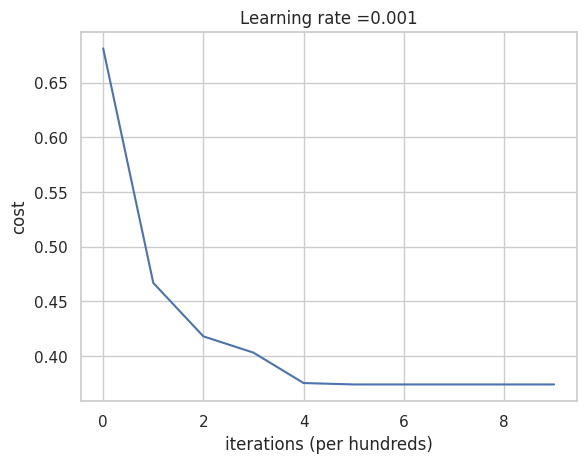

In [18]:
layer_dims = [3, 100, 100, 100, 100, 20, 1]
parameters, costs = L_layer_model(train_x, train_y, layer_dims, learning_rate=0.001, print_cost=True)
plot_costs(costs, learning_rate=0.001)

In [19]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))

    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    #print results
    print("predictions: " + str(p))
    print("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))

    return p

In [20]:
predictions_train = predict(train_x, train_y, parameters)

predictions: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
  1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 0. 0.]]
true labels: [[0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0
  1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 

In [21]:
predictions_test = predict(test_x, test_y, parameters)

predictions: [[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.]]
true labels: [[1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0
  0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0]]
Accuracy: 0.7704918032786887
